In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import time
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from einops import rearrange
from tqdm import tqdm

## Описание

Baseline для сравнения с VSSD: ConvMixer - CNN архитектура с depthwise + pointwise conv

In [2]:
# S6 блок для state space модели
class S6(nn.Module):
    def __init__(self, d_model, d_state=8):
        super().__init__()
        self.d_model = d_model
        self.d_state = d_state
        self.A_log = nn.Parameter(torch.randn(d_model, d_state))
        self.D = nn.Parameter(torch.ones(d_model))
        self.B = nn.Parameter(torch.randn(d_model, d_state) * 0.01)
        self.C = nn.Parameter(torch.randn(d_model, d_state) * 0.01)
        self.dt_proj = nn.Linear(d_model, d_model, bias=False)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        b, l, d = x.shape
        A = -F.softplus(self.A_log)
        dt = F.softplus(self.dt_proj(x)).clamp(0.001, 0.1)
        h = torch.zeros(b, d, self.d_state, device=x.device, dtype=x.dtype)
        out = []
        for t in range(l):
            dt_t = dt[:, t, :].unsqueeze(-1)
            A_bar = torch.exp(A.unsqueeze(0) * dt_t)
            B_bar = self.B.unsqueeze(0) * dt_t
            x_t = x[:, t, :].unsqueeze(-1)
            h = A_bar * h + B_bar * x_t
            y = torch.sum(h * self.C.unsqueeze(0), dim=-1) + self.D.unsqueeze(0) * x[:, t, :]
            out.append(y)
        return self.norm(torch.stack(out, dim=1))

# Двунаправленный Mamba
class BidirectionalMamba(nn.Module):
    def __init__(self, d_model, d_state=8):
        super().__init__()
        self.forward_s6 = S6(d_model, d_state)
        self.backward_s6 = S6(d_model, d_state)
        self.proj = nn.Linear(d_model * 2, d_model)

    def forward(self, x):
        fwd = self.forward_s6(x)
        bwd_in = torch.flip(x, dims=[1])
        bwd = torch.flip(self.backward_s6(bwd_in), dims=[1])
        return self.proj(torch.cat([fwd, bwd], dim=-1))

# Блок VSSD
class VSSDBlock(nn.Module):
    def __init__(self, d_model, d_state=8, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(d_model)
        self.mamba = BidirectionalMamba(d_model, d_state)
        self.dropout1 = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_model * 3), nn.GELU(), nn.Dropout(dropout),
            nn.Linear(d_model * 3, d_model), nn.Dropout(dropout)
        )

    def forward(self, x):
        x = x + self.dropout1(self.mamba(self.norm1(x)))
        x = x + self.ffn(self.norm2(x))
        return x

# Модель VSSD
class VSSD(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_channels=3, num_classes=10,
                 d_model=128, d_state=8, n_layers=4, dropout=0.1):
        super().__init__()
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.patch_embed = nn.Sequential(
            nn.Linear(in_channels * patch_size * patch_size, d_model),
            nn.LayerNorm(d_model)
        )
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches, d_model) * 0.02)
        self.dropout = nn.Dropout(dropout)
        self.blocks = nn.ModuleList([VSSDBlock(d_model, d_state, dropout) for _ in range(n_layers)])
        self.norm = nn.LayerNorm(d_model)
        self.head = nn.Sequential(
            nn.Linear(d_model, d_model), nn.GELU(), nn.Dropout(dropout),
            nn.Linear(d_model, num_classes)
        )
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        b, c, h, w = x.shape
        p = self.patch_size
        x = rearrange(x, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=p, p2=p)
        x = self.patch_embed(x)
        x = x + self.pos_embed
        x = self.dropout(x)
        for block in self.blocks:
            x = block(x)
        x = self.norm(x)
        x = x.mean(dim=1)
        return self.head(x)


In [3]:
# Блок ConvMixer
class ConvMixerBlock(nn.Module):
    def __init__(self, dim, kernel_size=9):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(dim, dim, kernel_size, groups=dim, padding=kernel_size//2),
            nn.GELU(), nn.BatchNorm2d(dim)
        )
        self.pointwise = nn.Sequential(
            nn.Conv2d(dim, dim, 1), nn.GELU(), nn.BatchNorm2d(dim)
        )

    def forward(self, x):
        x = x + self.conv(x)
        return self.pointwise(x)

# Модель ConvMixer
class ConvMixer(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_channels=3, num_classes=10,
                 dim=256, depth=8, kernel_size=9):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(in_channels, dim, kernel_size=patch_size, stride=patch_size),
            nn.GELU(), nn.BatchNorm2d(dim)
        )
        self.blocks = nn.Sequential(*[ConvMixerBlock(dim, kernel_size) for _ in range(depth)])
        self.pooling = nn.AdaptiveAvgPool2d(1)
        self.head = nn.Linear(dim, num_classes)

    def forward(self, x):
        x = self.stem(x)
        x = self.blocks(x)
        x = self.pooling(x).flatten(1)
        return self.head(x)


In [4]:
# Загрузка данных CIFAR-10
def get_dataloaders(batch_size=128):
    trf_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    trf_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    ds_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=trf_train)
    ds_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=trf_test)
    dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    dl_test = DataLoader(ds_test, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    return dl_train, dl_test


In [5]:
# Обучение на одной эпохе
def train_epoch(m, dl, crit, opt, dev):
    m.train()
    loss_sum, correct, total = 0, 0, 0
    for img, lbl in tqdm(dl, leave=False, desc='Обучение'):
        img, lbl = img.to(dev), lbl.to(dev)
        opt.zero_grad()
        out = m(img)
        loss = crit(out, lbl)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(m.parameters(), 1.0)
        opt.step()
        loss_sum += loss.item()
        _, pred = out.max(1)
        total += lbl.size(0)
        correct += pred.eq(lbl).sum().item()
    return loss_sum / len(dl), 100. * correct / total

# Оценка модели
def evaluate(m, dl, dev):
    m.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for img, lbl in tqdm(dl, leave=False, desc='Оценка'):
            img, lbl = img.to(dev), lbl.to(dev)
            _, pred = m(img).max(1)
            total += lbl.size(0)
            correct += pred.eq(lbl).sum().item()
    return 100. * correct / total

# Подсчёт параметров
def count_params(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)

# Запуск эксперимента
def run_experiment(m_type='vssd', epochs=40, lr=5e-4):
    dl_train, dl_test = get_dataloaders(batch_size=128)
    if m_type == 'vssd':
        m = VSSD(d_model=192, d_state=16, n_layers=6, dropout=0.1).to(device)
    else:
        m = ConvMixer(dim=192, depth=6, kernel_size=9).to(device)
    crit = nn.CrossEntropyLoss(label_smoothing=0.1)
    opt = torch.optim.AdamW(m.parameters(), lr=lr, weight_decay=0.05)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs, eta_min=1e-6)
    hist = {'train_loss': [], 'train_acc': [], 'test_acc': [], 'epoch_time': []}
    best = 0
    for ep in range(epochs):
        t_start = time.time()
        loss_tr, acc_tr = train_epoch(m, dl_train, crit, opt, device)
        acc_te = evaluate(m, dl_test, device)
        t_epoch = time.time() - t_start
        sched.step()
        hist['train_loss'].append(loss_tr)
        hist['train_acc'].append(acc_tr)
        hist['test_acc'].append(acc_te)
        hist['epoch_time'].append(t_epoch)
        if acc_te > best:
            best = acc_te
        print(f"Эпоха {ep+1}/{epochs} | Loss: {loss_tr:.4f} | "
              f"Train: {acc_tr:.2f}% | Test: {acc_te:.2f}% | "
              f"Время: {t_epoch:.1f}s | Лучший: {best:.2f}%")
    return m, hist, best



In [6]:
# Визуализация сравнения
def plot_comparison(res_dict):
    fig, ax = plt.subplots(2, 2, figsize=(14, 10))
    for name, hist in res_dict.items():
        ax[0, 0].plot(hist['train_loss'], label=name, linewidth=2)
        ax[0, 1].plot(hist['train_acc'], label=name, linewidth=2)
        ax[1, 0].plot(hist['test_acc'], label=name, linewidth=2)
    ax[0, 0].set_title('Loss на обучении', fontsize=14, fontweight='bold')
    ax[0, 0].set_xlabel('Эпоха')
    ax[0, 0].set_ylabel('Loss')
    ax[0, 0].legend()
    ax[0, 0].grid(True, alpha=0.3)
    ax[0, 1].set_title('Accuracy на обучении', fontsize=14, fontweight='bold')
    ax[0, 1].set_xlabel('Эпоха')
    ax[0, 1].set_ylabel('Accuracy (%)')
    ax[0, 1].legend()
    ax[0, 1].grid(True, alpha=0.3)
    ax[1, 0].set_title('Accuracy на тесте', fontsize=14, fontweight='bold')
    ax[1, 0].set_xlabel('Эпоха')
    ax[1, 0].set_ylabel('Accuracy (%)')
    ax[1, 0].legend()
    ax[1, 0].grid(True, alpha=0.3)
    avg_t = {n: np.mean(h['epoch_time']) for n, h in res_dict.items()}
    ax[1, 1].bar(list(avg_t.keys()), list(avg_t.values()), color=['#2ecc71', '#e74c3c'])
    ax[1, 1].set_title('Среднее время эпохи', fontsize=14, fontweight='bold')
    ax[1, 1].set_ylabel('Время (сек)')
    ax[1, 1].grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig('vssd_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

# Вывод итоговой таблицы
def print_summary_table(res_dict, params_dict, best_accs):
    print("\n" + "="*100)
    print("ИТОГОВЫЕ РЕЗУЛЬТАТЫ")
    print("="*100)
    print(f"{'Модель':<20} {'Параметры':<15} {'Лучший Test Acc':<15} {'Финальный Test Acc':<15} {'Среднее время':<15}")
    print("-"*100)
    for name, hist in res_dict.items():
        p = f"{params_dict[name]/1e6:.2f}M"
        best = best_accs[name]
        final = hist['test_acc'][-1]
        avg_t = np.mean(hist['epoch_time'])
        print(f"{name:<20} {p:<15} {best:<15.2f}% {final:<15.2f}% {avg_t:<15.1f}s")
    print("="*100)




[1/2] Обучение VSSD (Vision Mamba с Non-Causal State Space Duality)


100%|██████████| 170M/170M [00:12<00:00, 13.6MB/s]


Эпоха 1/2 | Loss: 2.0009 | Train: 26.82% | Test: 30.13% | Время: 305.5s | Лучший: 30.13%


Эпоха 2/2 | Loss: 1.8624 | Train: 33.57% | Test: 35.16% | Время: 307.5s | Лучший: 35.16%
Параметры VSSD: 2.40M

[2/2] Обучение ConvMixer (Baseline)


Эпоха 1/2 | Loss: 1.6894 | Train: 44.41% | Test: 52.07% | Время: 24.3s | Лучший: 52.07%


Эпоха 2/2 | Loss: 1.4495 | Train: 56.64% | Test: 57.80% | Время: 22.1s | Лучший: 57.80%
Параметры ConvMixer: 0.33M

ИТОГОВЫЕ РЕЗУЛЬТАТЫ
Модель               Параметры       Лучший Test Acc Финальный Test Acc Среднее время  
----------------------------------------------------------------------------------------------------
VSSD                 2.40M           35.16          % 35.16          % 306.5          s
ConvMixer            0.33M           57.80          % 57.80          % 23.2           s


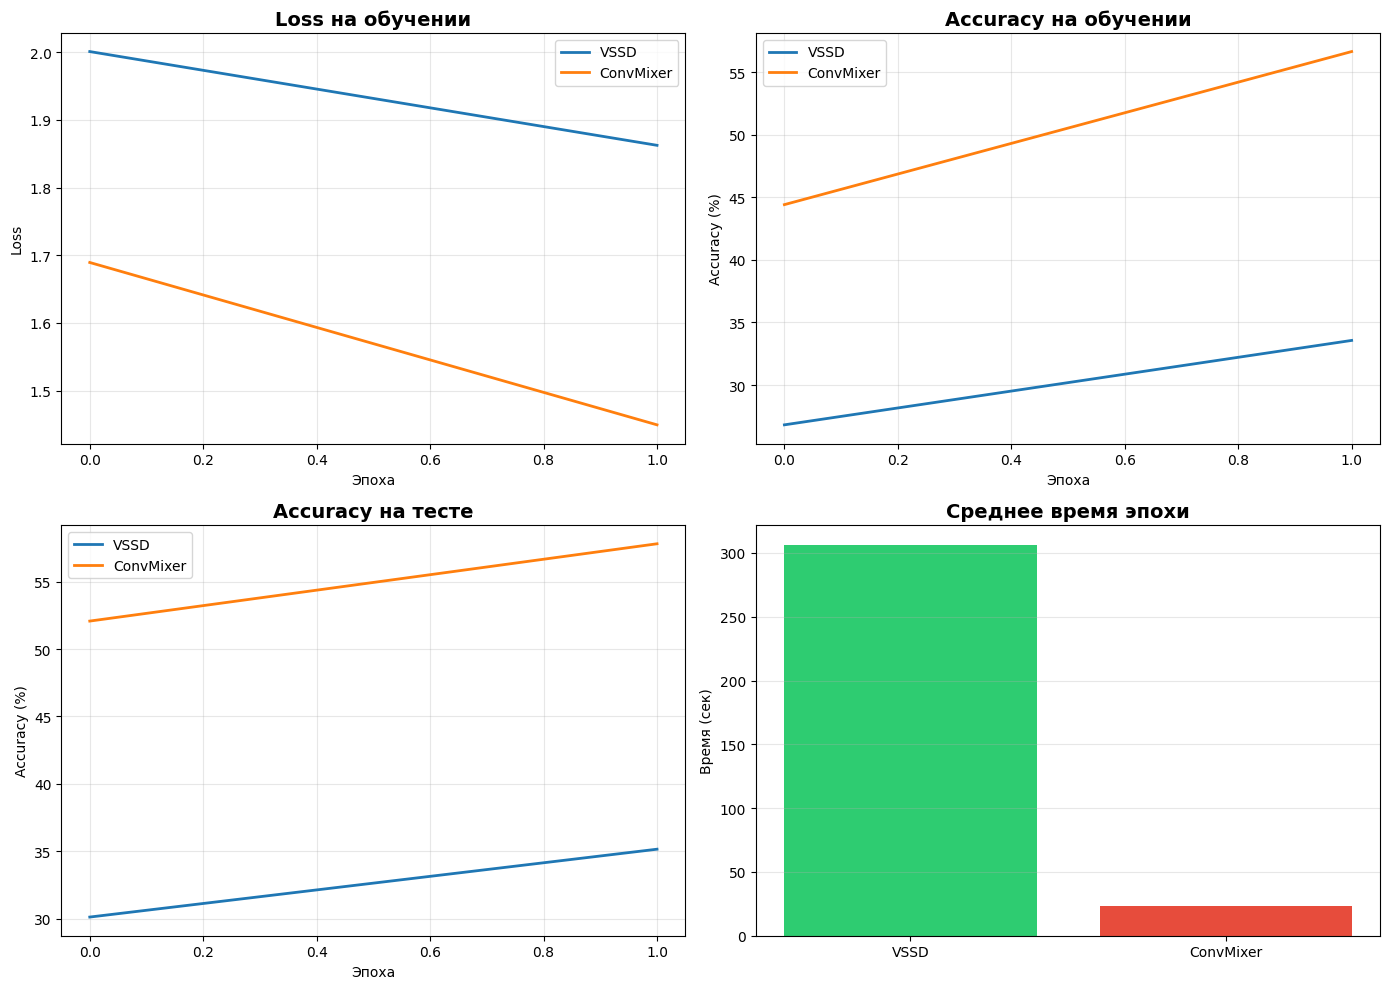

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

results = {}
params = {}
best_accs = {}

print("\n" + "="*100)
print("[1/2] Обучение VSSD (Vision Mamba с Non-Causal State Space Duality)")
print("="*100)
m_vssd, h_vssd, b_vssd = run_experiment(m_type='vssd', epochs=2, lr=5e-4)
results['VSSD'] = h_vssd
params['VSSD'] = count_params(m_vssd)
best_accs['VSSD'] = b_vssd
print(f"Параметры VSSD: {params['VSSD']/1e6:.2f}M")

print("\n" + "="*100)
print("[2/2] Обучение ConvMixer (Baseline)")
print("="*100)
m_conv, h_conv, b_conv = run_experiment(m_type='convmixer', epochs=2, lr=5e-4)
results['ConvMixer'] = h_conv
params['ConvMixer'] = count_params(m_conv)
best_accs['ConvMixer'] = b_conv
print(f"Параметры ConvMixer: {params['ConvMixer']/1e6:.2f}M")

print_summary_table(results, params, best_accs)
plot_comparison(results)

improvement = b_vssd - b_conv

## Выводы

Оказывается, что ConvMixer выдаёт лучшее accuracy при намного более легковесной архитектуре